<a href="https://colab.research.google.com/github/theTijesuni/Fall2022-EEC151/blob/main/UCD_EEC151_FQ2022_CA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Computer Assignment 2 

## Problem Statement

The goal of this computer assignment is to learn how to apply the FFT as a tool for data compression.

Assume that we have a long, real data record that we would like to compress.  Let's suppose that the storage for a sample is fixed -- usually it's around 16 bits (2 bytes) per real sample.  If we want to store the data record uncompressed, then it takes (2 bytes)*(number of real samples).  In general, for a signal with N samples/data vlaues, we know it takes an N-point FFT to represent its transform.  However, we can reduce the number of bytes to store the data record as follows.  

(1) Recall that the DFT/FFT of a real signal is conjugate symmetric.  That means we can throw away half of the FFT samples, the ones corresponding to negative frequencies [-pi,0), because we can reconstruct them from the positive frequency values [0,pi].  However, this by itself doesn't save any data  because the values of the FFT are complex and it takes twice as many bytes to store complex samples.  So with this "trick" we have only gotten back to the original number of bytes.

(2) Of the FFT values corresponding to the positive frequencies [0,pi], we will sort them by magnitude and only store the largest ones.  This is where the data savings comes from.  We will need to store the indicies of the samples we keep, but that small increase should be offset by the amount of data we save.  Moreover, we can set an adjustable threshold and come up with a variable-compression algorithm.

The technique demonstrated here is the core of many modern data compression techniques.  

### A note on things outside the scope of this assignment
For this exercise we will ignore quanitization error in the data, and the effect of quantization on the FFT samples.  There are ways to adjust for and mitigate against it, but we will simply ignore it for this assignment.

We will not actually store the compressed file, but we will simulate reconstruction from a portion of the FFT spectrum.



## Simple version / Example

In order to demonstrate the functions involved, the next section will demonstrate a simple version of this technique.  In this simple version, we 
will reconstruct the signal using just a single FFT sample.

Using N = 1024
percent energy captured in reconstructed signal (freq domain): 98.0%
percent energy captured in reconstructed signal (time domain): 98.0%


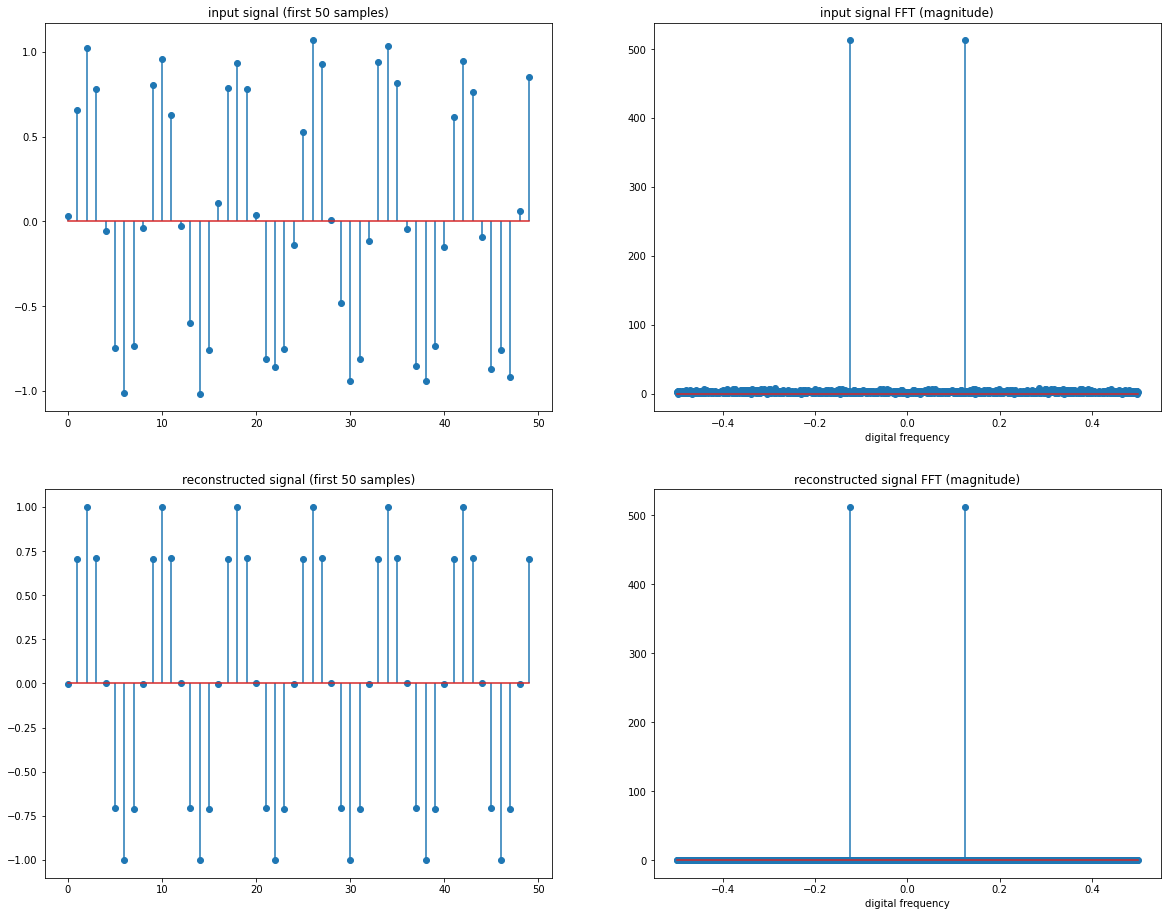

In [ ]:
# EEC 151
# Computer Assignment 2
# 
# FFT for data compression.
#
# STUDENTS, YOU DON'T HAVE TO MODIFY THIS CELL--IT IS FOR REFERENCE ONLY
# You may, however, want to step through it to understand how it works.
#
# IMPORTS
import numpy as np
import scipy as sp
import scipy.fft as scipyfft
import matplotlib.pyplot as plt
from urllib.request import urlopen

# Simple example: tone (sine wave) + noise

n = np.arange(1024)
data = np.sin(0.25*np.pi*n)
noise = 0.1*np.random.randn(data.size)
sig = data + noise

f = plt.figure(figsize=[20,5])
plt.subplots_adjust(top=2.5) 

ax1 = f.add_subplot(2,2,1)
ax1.stem(sig[0:50],use_line_collection=True)
ax1.set(title="input signal (first 50 samples)")

# compute the FFT
# note, we could use the `rfft()` function which is designed for real inputs, 
# but we'll use the general FFT 

N = (2**np.ceil(np.log2(len(sig)))).astype(int) # find next largest power of 2, cast to int
# note: without the "cast" `astype()`, the fft function barfs
print("Using N = %d"%N)

S = scipyfft.fft(sig,N) 
# S contains the full FFT, with coefficients every (2*pi*k/N) for k = 0,...,N
S_freq = scipyfft.fftfreq(N) # giving no second argument will give us linear digital frequencies [0,1)
                           # which corresponds to the range [0,2*pi) in radian digital frequency

# plot the magnitude of the FFT
#f = plt.figure()

ax2 = f.add_subplot(2,2,2)
ax2.stem(scipyfft.fftshift(S_freq),scipyfft.fftshift(np.absolute(S)),use_line_collection=True)
# fftshift() will plot the x-axis from [-pi,+pi) radians or [-0.5,+0.5) linear frequency units
ax2.set_xlabel("digital frequency")
ax2.set(title="input signal FFT (magnitude)")

# take half FFT
S_half = S[0:(N//2)] # this is the first half of coefficents, for k = 0,...,(N/2-1)

# sort by magnitude in descending order
S_half_sort_index = np.argsort(np.absolute(S_half)) # sort() works in ascending order only
S_half_sort_index = np.flip(S_half_sort_index) # this flips the index around so it's in descending order

# find largest single index
sort_index_max = S_half_sort_index[0]
#print("DEBUG: S[%d] = %+.1f %+.1fj"%(sort_index_max,np.real(S[sort_index_max]),np.imag(S[sort_index_max])))
#print("DEBUG: S[%d] = %+.1f %+.1fj"%(N-sort_index_max,np.real(S[N-sort_index_max]),np.imag(S[N-sort_index_max])))

# signal reconstructed from the single largest FFT value
S_reconstruct = np.zeros(S.size,dtype=np.complex64)

S_reconstruct[sort_index_max] = S_half[sort_index_max] # note this indexes into S and takes the complex value at the right index

# now reconstruct the other half of the FFT values using conjugate symmetry
for i in range(N//2):
  S_reconstruct[N-1-i] = np.conjugate(S_reconstruct[i+1])
#print("DEBUG: S_reconstruct[%d] = %+.1f %+.1fj"%(sort_index_max,np.real(S_reconstruct[sort_index_max]),np.imag(S_reconstruct[sort_index_max])))
#print("DEBUG: S_reconstruct[%d] = %+.1f %+.1fj"%(N-sort_index_max-1,np.real(S_reconstruct[N-sort_index_max-1]),np.imag(S_reconstruct[N-sort_index_max-1])))
#print("DEBUG: S_reconstruct[%d] = %+.1f %+.1fj"%(N-sort_index_max+0,np.real(S_reconstruct[N-sort_index_max+0]),np.imag(S_reconstruct[N-sort_index_max+0])))
#print("DEBUG: S_reconstruct[%d] = %+.1f %+.1fj"%(N-sort_index_max+1,np.real(S_reconstruct[N-sort_index_max+1]),np.imag(S_reconstruct[N-sort_index_max+1])))

# plot the magnitude of the saved FFT values
#f = plt.figure()

ax3 = f.add_subplot(2,2,4)
ax3.stem(scipyfft.fftshift(S_freq),scipyfft.fftshift(np.absolute(S_reconstruct)),use_line_collection=True)
# fftshift() will plot the x-axis from [-pi,+pi) radians or [-0.5,+0.5) linear frequency units
ax3.set_xlabel("digital frequency")
ax3.set(title="reconstructed signal FFT (magnitude)")

# use inverse FFT to get back a time-domain signal
sig_reconstructed = scipyfft.ifft(S_reconstruct)
sig_reconstructed_real = np.real( sig_reconstructed )
# In theory this should give us a purely real result back, 
# but due to numerical effects there is a small residual imaginary component.  
# Therefore, wrap the call in `np.real()`
total_power = np.sum(np.power(np.absolute(sig_reconstructed),2.0)) 
total_power_real = np.sum(np.power(np.absolute(sig_reconstructed_real),2.0)) 
assert( (total_power-total_power_real) < 0.10*total_power ) # sanity check
# if the above assertion fails, then the argument to `ifft()` was NOT conjugate symmetric

# calculate percent of energy in reconstructed signal

# method 1: frequency domain
percent_energy_freqdomain = 100 * np.sum(np.power(np.absolute(S_reconstruct),2.0)) / np.sum(np.power(np.absolute(S),2.0))

# method 2: time domain
percent_energy_timedomain = 100 * np.sum(np.power(np.absolute(sig_reconstructed_real),2.0)) / np.sum(np.power(np.absolute(sig),2.0))

print("percent energy captured in reconstructed signal (freq domain): %.1f%%"%(percent_energy_freqdomain))
print("percent energy captured in reconstructed signal (time domain): %.1f%%"%(percent_energy_timedomain))
# sanity check: these two estimates should produce the same number
# (Due to numerical effects in the ifft, this may not be exactly true here)
# (This is why for serious work, you would want to use `rfft()` and `rifft()`)

# plot reconstructed signal
#f = plt.figure()

ax4 = f.add_subplot(2,2,3)
ax4.stem(np.real(sig_reconstructed_real[0:50]),use_line_collection=True)
ax4.set(title="reconstructed signal (first 50 samples)")

#f = plt.figure()
#ax5 = f.add_subplot(1,1,1)
#ax5.stem(np.imag(sig_reconstructed[0:50]),use_line_collection=True)
#ax5.set(title="reconstructed signal, imag (first 50 samples)")

plt.show()


## Question

In the above example, we used just a single FFT value and reconstructed the signal very well.  Why was that so?  What is special about the input signal in that case?  

(5 points) STUDENTS ADD ANSWER HERE

## Coding Portion

Now it's your turn!

Below is some partial code with comments to get you started.

### (1) Parameters
There is a single parameter `compression_percent`, that may be set between 0 and 100.  The interpretation of this parameter is the following: after sorting the FFT values by magnitude, save the largest `compression_percent` percent of them.  

Note that `compression_percent = 0` will save 0 FFT values and capture none of the signal.  `compression_percent = 100` will save all of the FFT values and capture 100% of the signal, but give us no compression.  The number of coefficients kept should be `N_to_keep = (np.ceil(compression_percent/100*len(data)//2)).astype(int)`.

Turn in your code with a `compression_percent` which has  "good sound" to your ear--you may be surprised how low you can go and still hear the audio very well.  The TAs will change this value during grading and your code should run with other values set!  

### (2) Load the data
This portion will be done for you.  The data record you will be dealing with is an audio clip.

### (3) Run your data compression simulation
Compute the FFT, sort the FFT values by magnitude, and keep the largest `compression_percent` of them.  Round up if the number of FFT values to store works out to be a decimal.  There is some template code to get you started.

### (4) Reconstruct the signal from the largest FFT components
Use the inverse FFT to reconstructe the signal.

### (5) Plot the results
Plot the full FFT and the partial/saved FFT components.  Insert code where shown.

In [ ]:

!pip install soundfile

# run this cell once per session

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# play the uncompressed input file (just for reference)
import IPython

# play the uncompressed audio
print("Play Input (uncompressed) File:")
IPython.display.Audio('https://www.ece.ucdavis.edu/~njacklin/eec151/CA2/CantinaBand15.wav') 


Play Input (uncompressed) File:


Running with compression_percent = 90
length of input data record is 340378 samples
min/max values are: -0.339/+0.318
Using N = 524288
N_to_keep = 153170


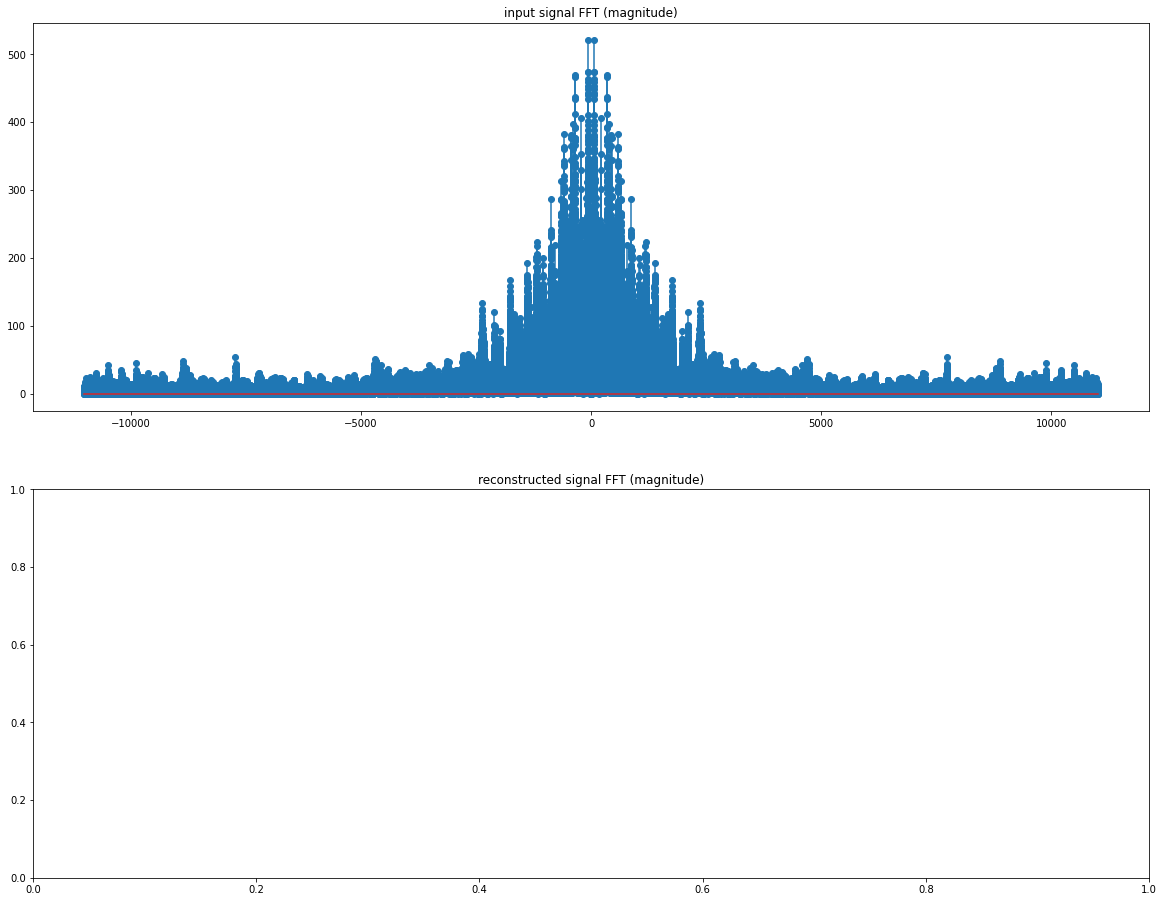

AssertionError: ignored

In [ ]:
# STUDENTS: EDIT THIS CELL

# IMPORTS -- you should not need to add imports!  
import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.fft as scipyfft
import matplotlib.pyplot as plt
from urllib.request import urlopen # open files from URL -- no saving required
import soundfile as sf
import io

input_url = 'https://www.ece.ucdavis.edu/~njacklin/eec151/CA2/CantinaBand15.wav'

# parameters
compression_percent = 90 # note: try other values!  
# (5 points -- your code should work with any value 1 - 100)

print("Running with compression_percent = %d"%compression_percent)

# load data as np array
data_raw, sampleRateHz = sf.read(io.BytesIO(urlopen(input_url).read()))
data = np.array(data_raw) # data as a numpy array
L = len(data)
print("length of input data record is %d samples"%L)
print("min/max values are: %+.3f/%+.3f"%(np.min(data),np.max(data)))

# compute FFT and FFT frequencies

N = (2**np.ceil(np.log2(L))).astype(int) # find next largest power of 2, cast to int
# note: without the "cast" `astype()`, the fft function barfs
print("Using N = %d"%N)

S = scipyfft.fft(data,N) 
# S contains the full FFT, with coefficients every (2*pi*k/N) for k = 0,...,N
S_freq = scipyfft.fftfreq(N,(1.0/sampleRateHz))

# (0 points -- code provided) plot original FFT 
f = plt.figure(figsize=[20,5])
plt.subplots_adjust(top=2.5) 

ax2 = f.add_subplot(2,1,1)
ax2.stem(scipyfft.fftshift(S_freq),scipyfft.fftshift(np.absolute(S)),use_line_collection=True)
ax2.set(title="input signal FFT (magnitude)")

# (5 points) find largest FFT values, from the half FFT 

# temporarily store half FFT
# ADD CODE

# sort by magnitude in descending order
# ADD CODE

# compute N_to_keep
N_to_keep = (np.ceil(compression_percent/100*L//2)).astype(int)
print("N_to_keep = %d"%N_to_keep)

# signal reconstructed from the single largest FFT value
S_reconstruct = np.zeros(S.size,dtype=np.complex64)

# ADD CODE

# now reconstruct the other half of the FFT values using conjugate symmetry
# ADD CODE

# (5 points, for correct looking plot) plot FFT showing saved values only  
# note: don't forget to add units to x axis label on plot

ax3 = f.add_subplot(2,1,2)
# ADD PLOT CODE HERE

ax3.set(title="reconstructed signal FFT (magnitude)")

plt.show()

# (0 points -- code provided) reconstruct the original signal from the partial FFT 
# note: for boilerplate code cell below, labeled "playback reconstructed wav file",
#       make sure the reconstructed audio file is "reconstructed.wav"

# use inverse FFT to get back a time-domain signal
data_reconstructed = scipyfft.ifft(S_reconstruct)
data_reconstructed_real = np.real( data_reconstructed[0:len(data)] )
# In theory this should give us a purely real result back, 
# but due to numerical effects there is a small residual imaginary component.  
# Therefore, wrap the call in `np.real()`
total_power = np.sum(np.power(np.absolute(data_reconstructed),2.0)) # DEBUG
total_power_real = np.sum(np.power(np.absolute(data_reconstructed_real),2.0)) # DEBUG
if compression_percent > 0: # DEBUG
  assert( (total_power-total_power_real) < 0.10*total_power ) # DEBUG / sanity check
  # if the above assertion fails, then the argument to `ifft()` was NOT conjugate symmetric
# NOTE TO STUDENTS: comment out the above DEBUG CODE if you want... 

print("length of reconstructed data record is %d samples"%len(data_reconstructed_real))
print("min/max values are: %+.3f/%+.3f"%(np.min(data_reconstructed_real),np.max(data_reconstructed_real)))

# (5 points) print energy in frequency domain and time domain
# note: you may need to use some try/except logic or 
#       if/else statement to handle the compression_percent = 0 case, 
#       to avoid division by zero here

# ADD CODE

# sanity check: these two estimates should produce the same number
# (Due to numerical effects in the ifft, this may not be exactly true here)
# (This is why for serious work, you would want to use `rfft()` and `rifft()`)

# (0 points -- code provided) write out audio as 16bit PCM WAV
sf.write('reconstructed.wav', data_reconstructed_real, sampleRateHz, subtype='PCM_16')
print("reconstructed wave file written to temp running directory")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

# playback reconstructed wav file
import IPython

print("Play Reconstructed File:")
IPython.display.Audio('reconstructed.wav') 


## Enhancements

There are several things that we could do to improve the performance of this compression technique.

It is not necessary to implement these enhancements, and no attempt to integrate them will be graded.  However, they are provided for further reading if you are interested in the subject.

### Use different transform
Variations of the FFT exist which are better for  compression task.  For example, the Discrete Cosine Transform (DCT) has a so-called energy compaction property which could be more efficient.  See for further reading:
*   https://www.sciencedirect.com/topics/engineering/energy-compaction
*   https://en.wikipedia.org/wiki/Discrete_cosine_transform
*   https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.dct.html

The theory of Wavelets is also based on the transform concept, although with several adjustments.  Wavelet transforms are used in very popular compression standards such as JPEG.
*   https://en.wikipedia.org/wiki/Wavelet_transform

### Smaller block size
In this example, the input data record is 15 seconds long and the frequency content changes throughout.  If we took smaller block sizes, for example about 500 ms or 100 ms long, we might get better compression on each block than we can achieve from processing the entire file at once.  This is similar to looking at the spectrogram vs. the FFT of the whole signal.


